# Classification
### Step 1: resize/crop images
Requires having run: `beescrape.py`
Depends on yolov5 and `shutil`

In [1]:
# init
import os
from os import listdir
from shutil import copyfile
import shutil
from PIL import Image
import skimage
import random
import numpy as np

# Directories
DATA_DIR = '/home/wilber/Documents/RESEARCH/research/beespotter'
OUT_DIR = '/m2docs/res/data'
CROPPED_PATH = '/m2docs/res/cropped_imgs'
cropped_files = listdir(CROPPED_PATH)

# Args:
VAL_SIZE = 256
TEST_SIZE = 128
preprocess = True
resize = True
length = 256
size = (length, length) # (512, 512)

# Uncropped args: (use the same images except without passing through yolo bee finder for comparison)
OUT_DIR_RAW = '/m2docs/res/data_raw'
UNCROPPED_PATH = '/m2docs/res/uncropped_imgs'
COPY_UNCROPPED = True

# Species with >= 1000 images:
classes = ['Apis_mellifera','Bombus_impatiens','Bombus_auricomus','Bombus_bimaculatus','Bombus_griseocollis']


In [8]:
%rm -R /m2docs/res/data/*
%rm -R /m2docs/res/data_raw/*

print("resizing images to {}".format(size))

# from https://gist.github.com/Prasad9/28f6a2df8e8d463c6ddd040f4f6a028a
noise_modes = [None,'salt','pepper','s&p']
NOISE_AMOUNT = .01 # default amount
def add_noise(img, mode, noise_amount = .03):
    if mode is not None:
        gimg = skimage.util.random_noise(img, mode = mode, amount = random.uniform(0,noise_amount))
        return gimg
    else:
        print("oops, you shouldn't see this")

total_skipped = 0
for label in classes:  # for each type of bee
    skipnum = 0
    classID = classes.index(label)
    
    input_path = os.path.join(DATA_DIR, label)
    im_list = os.listdir(input_path)
    random.shuffle(im_list)
    
    # Attempt to create directories:
    if not os.path.exists(OUT_DIR + '/train/' + label):
        os.makedirs(OUT_DIR + '/train/' + label)
    if not os.path.exists(OUT_DIR + '/test/' + label):
        os.makedirs(OUT_DIR + '/test/' + label)
    if not os.path.exists(OUT_DIR + '/valid/' + label):
        os.makedirs(OUT_DIR + '/valid/' + label)
    if not os.path.exists(OUT_DIR_RAW + '/train/' + label):
        os.makedirs(OUT_DIR_RAW + '/train/' + label)
    if not os.path.exists(OUT_DIR_RAW + '/test/' + label):
        os.makedirs(OUT_DIR_RAW + '/test/' + label)
    if not os.path.exists(OUT_DIR_RAW + '/valid/' + label):
        os.makedirs(OUT_DIR_RAW + '/valid/' + label)
        
    train_path = os.path.join(OUT_DIR,'train/'+ label + '/')
    test_path  = os.path.join(OUT_DIR,'test/' + label + '/')
    valid_path = os.path.join(OUT_DIR,'valid/' + label + '/')
    train_path_raw = os.path.join(OUT_DIR_RAW,'train/'+ label + '/')
    test_path_raw  = os.path.join(OUT_DIR_RAW,'test/' + label + '/')
    valid_path_raw = os.path.join(OUT_DIR_RAW,'valid/' + label + '/')
    
    index = 0
    for img in im_list:
        if img in cropped_files:
            pic = Image.open(os.path.join(CROPPED_PATH,img))
            
            if (COPY_UNCROPPED):
                    pic2 = Image.open(os.path.join(UNCROPPED_PATH,img))
            
            if resize: #resize image
                out = pic.resize(size)
                if (COPY_UNCROPPED):
                    out2 = pic2.resize(size)
            else:
                out = pic
                if (COPY_UNCROPPED):
                    out2 = pic2
            
            if index < VAL_SIZE:
                out.save(os.path.join(valid_path,img))
            elif index < VAL_SIZE + TEST_SIZE:
                out.save(os.path.join(test_path,img))
            if index < VAL_SIZE and COPY_UNCROPPED:
                out2.save(os.path.join(valid_path_raw,img))
            elif index < VAL_SIZE + TEST_SIZE and COPY_UNCROPPED:
                out2.save(os.path.join(test_path_raw,img))    
            else:    #training set, rotate
                out.save(os.path.join(train_path,img.replace('.jpg','-0.jpg')))
                if COPY_UNCROPPED:
                    out2.save(os.path.join(train_path_raw,img.replace('.jpg','-0.jpg')))
                if preprocess:
                    for rot,mode,ext in zip([random.randint(0,359),random.randint(0,359),random.randint(0,359)],[random.choice(noise_modes),random.choice(noise_modes),random.choice(noise_modes)],[1,2,3]):
                        #print(' ',img,rot,mode,ext,pic.mode)
                        if mode is not None:
                            Image.fromarray((add_noise(np.array(out.rotate(rot)),mode,NOISE_AMOUNT)*255).astype(np.uint8),pic.mode).save(os.path.join(train_path,img.replace('.jpg','-'+str(ext)+'.jpg')))
                            if COPY_UNCROPPED:
                                Image.fromarray((add_noise(np.array(out2.rotate(rot)),mode,NOISE_AMOUNT)*255).astype(np.uint8),pic2.mode).save(os.path.join(train_path_raw,img.replace('.jpg','-'+str(ext)+'.jpg')))
                        else:
                            out.rotate(rot).save(os.path.join(train_path,img.replace('.jpg','-'+str(ext)+'.jpg')))
                            if COPY_UNCROPPED:
                                out2.rotate(rot).save(os.path.join(train_path_raw,img.replace('.jpg','-'+str(ext)+'.jpg')))
                
        else:
            skipnum += 1
            index -= 1
            pass
        index += 1
    print(label, "skipped", skipnum)
    print(label, "total", index)
    
    total_skipped += skipnum
    
print("Images moved and rotated. Skipped ", total_skipped)

rm: cannot remove '/m2docs/res/data_raw/*': No such file or directory
resizing images to (256, 256)
Apis_mellifera skipped 1540
Apis_mellifera total 1217
Bombus_impatiens skipped 1296
Bombus_impatiens total 2017
Bombus_auricomus skipped 469
Bombus_auricomus total 724
Bombus_bimaculatus skipped 629
Bombus_bimaculatus total 1111
Bombus_griseocollis skipped 1111
Bombus_griseocollis total 1831
Images moved and rotated. Skipped  5045


In [10]:
import fnmatch
cropped_count = []
uncropped_count = []
for c in classes:
    print(c)
    cropped_count.append(len(fnmatch.filter(os.listdir(os.path.join(OUT_DIR + '/train/' + c + "/")), '*.jpg')))
    uncropped_count.append(len(fnmatch.filter(os.listdir(os.path.join(OUT_DIR_RAW + '/train/' + c + "/")), '*.jpg')))
    for t in ['/train/','/test/','/valid/']:
        print("images in {}: {}".format(t,len(fnmatch.filter(os.listdir(os.path.join(OUT_DIR + t + c + "/")), '*.jpg'))))
        print("images in {}: {} (uncropped)".format(t,len(fnmatch.filter(os.listdir(os.path.join(OUT_DIR_RAW + t + c + "/")), '*.jpg'))))
print(cropped_count)
print(uncropped_count)

Apis_mellifera
images in /train/: 3332
images in /train/: 3332 (uncropped)
images in /test/: 128
images in /test/: 128 (uncropped)
images in /valid/: 256
images in /valid/: 256 (uncropped)
Bombus_impatiens
images in /train/: 6532
images in /train/: 6532 (uncropped)
images in /test/: 128
images in /test/: 128 (uncropped)
images in /valid/: 256
images in /valid/: 256 (uncropped)
Bombus_auricomus
images in /train/: 1360
images in /train/: 1360 (uncropped)
images in /test/: 128
images in /test/: 128 (uncropped)
images in /valid/: 256
images in /valid/: 256 (uncropped)
Bombus_bimaculatus
images in /train/: 2908
images in /train/: 2908 (uncropped)
images in /test/: 128
images in /test/: 128 (uncropped)
images in /valid/: 256
images in /valid/: 256 (uncropped)
Bombus_griseocollis
images in /train/: 5788
images in /train/: 5788 (uncropped)
images in /test/: 128
images in /test/: 128 (uncropped)
images in /valid/: 256
images in /valid/: 256 (uncropped)
[3332, 6532, 1360, 2908, 5788]
[3332, 6532

In [11]:
# Flip images over axes to even out training sets:
import fnmatch
import os
from PIL import Image
import random
import skimage

classes = ['Apis_mellifera','Bombus_impatiens','Bombus_auricomus','Bombus_bimaculatus','Bombus_griseocollis']
ABS_PATH_TRAIN = '/m2docs/res/data/train'
MULTIPLIER = 1.2 # how many times more images need to be created: mult * len(largest class)
verbose = False

cropped_count = []
uncropped_count = []
for c in classes:
    print(c)
    cropped_count.append(len(fnmatch.filter(os.listdir(os.path.join(OUT_DIR + '/train/' + c + "/")), '*.jpg')))
    uncropped_count.append(len(fnmatch.filter(os.listdir(os.path.join(OUT_DIR_RAW + '/train/' + c + "/")), '*.jpg')))

print(classes)
print(cropped_count)
print(uncropped_count)

# add more images to largest class,
# and bring the others to the same count
target = max(cropped_count) * 1.1
print("Target number of images: {}".format(target))
    
print("Copying cropped images...")

noise_modes = [None,'salt','pepper','s&p']
NOISE_AMOUNT = .01 # default amount
def add_noise(img, mode, noise_amount = .03):
    if mode is not None:
        gimg = skimage.util.random_noise(img, mode = mode, amount = random.uniform(0, noise_amount))
        return gimg
    else:
        print("oops, you shouldn't see this")

for c_name in classes:
    current = cropped_count[classes.index(c_name)]
    if (verbose): 
        print(c_name, current, "->", target)
    im_list = os.listdir(os.path.join(ABS_PATH_TRAIN, c_name))
    while current < target:
        filename = random.choice(im_list)
        if(verbose):
            print(filename)
        out = Image.open(os.path.join(ABS_PATH_TRAIN, c_name, filename))
        
        rot = random.randint(0,359)
        mode = random.choice(noise_modes)
        if (verbose): 
            print(filename,rot,mode,out.mode)
        if (verbose): 
            print(filename.replace('.jpg','-x'+str(current)+'.jpg'))
        if mode is not None:
            Image.fromarray((add_noise(np.array(out.rotate(rot)),mode,NOISE_AMOUNT)*255).astype(np.uint8),pic.mode).save(os.path.join(ABS_PATH_TRAIN, c_name, filename.replace('.jpg','-x'+str(current)+'.jpg')))
        else:
            out.rotate(rot).save(os.path.join(ABS_PATH_TRAIN, c_name, filename.replace('.jpg','-x'+str(current)+'.jpg')))
        current += 1

cropped_count = []
for c in classes:
    cropped_count.append(len(fnmatch.filter(os.listdir(os.path.join(OUT_DIR + '/train/' + c + "/")), '*.jpg')))
print(cropped_count)
print("Done.\n")

if COPY_UNCROPPED:
    print("Copying uncropped images...")
    ABS_PATH_TRAIN_RAW = '/m2docs/res/data_raw/train'
    c_count = [len(fnmatch.filter(os.listdir(os.path.join(ABS_PATH_TRAIN_RAW,c_name)), '*')) for c_name in classes]
    print(classes)
    print(c_count)

    # add more images to largest class,
    # and bring the others to the same count
    print("Target count: n =",target)

    noise_modes = [None,'salt','pepper','s&p']
    NOISE_AMOUNT = .01 # default amount
    def add_noise(img, mode, noise_amount = .03):
        if mode is not None:
            gimg = skimage.util.random_noise(img, mode = mode, amount = random.uniform(0, noise_amount))
            return gimg
        else:
            print("oops, you shouldn't see this")

    for c_name in classes:
        current = uncropped_count[classes.index(c_name)]
        if (verbose): 
            print(c_name, current, "->", target)
        im_list = os.listdir(os.path.join(ABS_PATH_TRAIN_RAW, c_name))
        while current < target:
            filename = random.choice(im_list)
            if (verbose): 
                print(filename)
            out = Image.open(os.path.join(ABS_PATH_TRAIN_RAW, c_name, filename))

            rot = random.randint(0,359)
            mode = random.choice(noise_modes)
            if (verbose): 
                print(filename,rot,mode,out.mode)
            if (verbose): 
                print(filename.replace('.jpg','-x'+str(current)+'.jpg'))
            if mode is not None:
                Image.fromarray((add_noise(np.array(out.rotate(rot)),mode,NOISE_AMOUNT)*255).astype(np.uint8),pic.mode).save(os.path.join(ABS_PATH_TRAIN_RAW, c_name, filename.replace('.jpg','-x'+str(current)+'.jpg')))
            else:
                out.rotate(rot).save(os.path.join(ABS_PATH_TRAIN_RAW, c_name, filename.replace('.jpg','-x'+str(current)+'.jpg')))
            current += 1

    uncropped_count = []
    for c in classes:
        uncropped_count.append(len(fnmatch.filter(os.listdir(os.path.join(OUT_DIR_RAW + '/train/' + c + "/")), '*.jpg')))
    print(uncropped_count)
    print("Done.")

Apis_mellifera
Bombus_impatiens
Bombus_auricomus
Bombus_bimaculatus
Bombus_griseocollis
['Apis_mellifera', 'Bombus_impatiens', 'Bombus_auricomus', 'Bombus_bimaculatus', 'Bombus_griseocollis']
[3332, 6532, 1360, 2908, 5788]
[3332, 6532, 1360, 2908, 5788]
Target number of images: 7185.200000000001
Copying cropped images...
[7186, 7186, 7186, 7186, 7186]
Done.

Copying uncropped images...
['Apis_mellifera', 'Bombus_impatiens', 'Bombus_auricomus', 'Bombus_bimaculatus', 'Bombus_griseocollis']
[3332, 6532, 1360, 2908, 5788]
Target count: n = 7185.200000000001
[7186, 7186, 7186, 7186, 7186]
Done.


In [28]:
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os, datetime, math, io
import tensorflow as tf

from torch.utils.tensorboard import SummaryWriter 
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp 

print("Libraries loaded")

Libraries loaded


## feature visualizer
* [From Sovit Ranjan Rath](https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/)

* Adapted to work with any model passed into it.

In [29]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import argparse
from torchvision import models, transforms
from PIL import Image

def savefeatures(model, writer, image = "/m2docs/res/cropped_imgs/428-2.jpg"):
    if model is not None and writer is not None and image is not None:
        # load the model
        print(model)
        model_cpu = model.cpu()
        model_weights = [] # we will save the conv layer weights in this list
        conv_layers = [] # we will save the 49 conv layers in this list
        # get all the model children as list
        model_children = list(model_cpu.children())

        # counter to keep count of the conv layers
        counter = 0 
        # append all the conv layers and their respective weights to the list
        for i in range(len(model_children)):
            if type(model_children[i]) == nn.Conv2d:
                counter += 1
                model_weights.append(model_children[i].weight)
                conv_layers.append(model_children[i])
            elif type(model_children[i]) == nn.Sequential:
                for j in range(len(model_children[i])):
                    for child in model_children[i][j].children():
                        if type(child) == nn.Conv2d:
                            counter += 1
                            model_weights.append(child.weight)
                            conv_layers.append(child)
        print(f"Total convolutional layers: {counter}")

        # take a look at the conv layers and the respective weights
        for weight, conv in zip(model_weights, conv_layers):
            # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
            print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

        # visualize the first conv layer filters
        plt.figure(figsize=(20, 17))
        for i, filter in enumerate(model_weights[0]):
            plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
            plt.imshow(filter[0, :, :].detach(), cmap='gray')
            plt.axis('off')
            plt.savefig('outputs/filter.png')
        plt.show()

        # read and visualize an image
        img = cv.imread(f"{image}")
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
        # define the transforms
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
        ])
        img = np.array(img)
        # apply the transforms
        img = transform(img)
        print(img.size())
        # unsqueeze to add a batch dimension
        img = img.unsqueeze(0)
        print(img.size())

        # pass the image through all the layers
        results = [conv_layers[0](img)]
        for i in range(1, len(conv_layers)):
            # pass the result from the last layer to the next layer
            results.append(conv_layers[i](results[-1]))
        # make a copy of the `results`
        outputs = results

        # visualize 64 features from each layer 
        # (although there are more feature maps in the upper layers)
        for num_layer in range(len(outputs)):
            figure = plt.figure(figsize=(30, 30))
            layer_viz = outputs[num_layer][0, :, :, :]
            layer_viz = layer_viz.data
            print(layer_viz.size())
            for i, filter in enumerate(layer_viz):
                if i == 64: # we will visualize only 8x8 blocks from each layer
                    break
                plt.subplot(8, 8, i + 1)
                plt.imshow(filter, cmap='gray')
                plt.axis("off")
            print(f"Saving layer {num_layer} feature maps...")
            plt.savefig(f"outputs/layer_{num_layer}.png")
            writer.add_figure("features/layer_"+str(num_layer), figure)
            # plt.show()
            plt.close()
print("save_features loaded.")

save_features loaded.


## Train classifier
Based on [this](https://nextjournal.com/gkoehler/pytorch-mnist) pytorch tutorial

Load images and train classifier.

-> Starting trial run-0
{'channels': 64, 'dropout': 0.1, 'optimizer': 'sgd', 'processed (yolo)': False}
Running using uncropped (plain) images
Device: cuda:0
Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)


<class 'torch.nn.parameter.Parameter'>
  Epoch: 0 [7/32/35930 (0%)]	Loss: 1.600778	Acc: 21.875000%
  Epoch: 0 [1293/6432/35930 (18%)]	Loss: 1.609180	Acc: 20.102612%
  Epoch: 0 [2571/12832/35930 (36%)]	Loss: 1.621153	Acc: 20.035848%
  Epoch: 0 [3847/19232/35930 (53%)]	Loss: 1.608681	Acc: 20.003120%
  Epoch: 0 [5141/25632/35930 (71%)]	

  Epoch: 12 [1967/6432/35930 (18%)]	Loss: 1.532084	Acc: 30.581468%
  Epoch: 12 [3978/12832/35930 (36%)]	Loss: 1.554786	Acc: 31.000623%
  Epoch: 12 [5938/19232/35930 (53%)]	Loss: 1.433006	Acc: 30.875624%
  Epoch: 12 [7997/25632/35930 (71%)]	Loss: 1.473131	Acc: 31.199282%
  Epoch: 12 [10096/32032/35930 (89%)]	Loss: 1.537718	Acc: 31.518482%
Epoch: 12	Loss: 1.523442	Acc: 31.614250
 Validation correct: 376.0 / 1280
Validation: acc: 29.375000%	loss: 0.048003
 Testing correct: 203.0 / 640
Testing: acc: 31.718750%	loss: -3.407022
Best: 11 @ 29.921875% -> epoch target 16
  Epoch: 13 [6/32/35930 (0%)]	Loss: 1.610744	Acc: 18.750000%
  Epoch: 13 [2089/6432/35930 (18%)]	Loss: 1.524533	Acc: 32.478234%
  Epoch: 13 [4113/12832/35930 (36%)]	Loss: 1.585546	Acc: 32.052681%
  Epoch: 13 [6187/19232/35930 (53%)]	Loss: 1.564094	Acc: 32.170341%
  Epoch: 13 [8271/25632/35930 (71%)]	Loss: 1.555916	Acc: 32.268258%
  Epoch: 13 [10361/32032/35930 (89%)]	Loss: 1.470501	Acc: 32.345779%
Epoch: 13	Loss: 1.511445	Acc: 

  Epoch: 25 [2503/6432/35930 (18%)]	Loss: 1.576328	Acc: 38.914801%
  Epoch: 25 [4938/12832/35930 (36%)]	Loss: 1.252216	Acc: 38.481920%
  Epoch: 25 [7308/19232/35930 (53%)]	Loss: 1.389336	Acc: 37.999168%
  Epoch: 25 [9706/25632/35930 (71%)]	Loss: 1.387331	Acc: 37.866729%
  Epoch: 25 [12083/32032/35930 (89%)]	Loss: 1.610407	Acc: 37.721653%
Epoch: 25	Loss: 1.428989	Acc: 37.820763
 Validation correct: 473.0 / 1280
Validation: acc: 36.953125%	loss: 0.045157
 Testing correct: 227.0 / 640
Testing: acc: 35.468750%	loss: -3.548290
Best: 23 @ 37.031250% -> epoch target 28
  Epoch: 26 [11/32/35930 (0%)]	Loss: 1.523972	Acc: 34.375000%
  Epoch: 26 [2386/6432/35930 (18%)]	Loss: 1.570246	Acc: 37.095771%
  Epoch: 26 [4851/12832/35930 (36%)]	Loss: 1.341617	Acc: 37.803928%
  Epoch: 26 [7356/19232/35930 (53%)]	Loss: 1.475221	Acc: 38.248752%
  Epoch: 26 [9848/25632/35930 (71%)]	Loss: 1.432898	Acc: 38.420724%
  Epoch: 26 [12334/32032/35930 (89%)]	Loss: 1.434627	Acc: 38.505245%
Epoch: 26	Loss: 1.419106	Acc:

  Epoch: 38 [3039/6432/35930 (18%)]	Loss: 1.225351	Acc: 47.248134%
  Epoch: 38 [6123/12832/35930 (36%)]	Loss: 1.223379	Acc: 47.716646%
  Epoch: 38 [9233/19232/35930 (53%)]	Loss: 1.293257	Acc: 48.008527%
  Epoch: 38 [12358/25632/35930 (71%)]	Loss: 1.469709	Acc: 48.213171%
  Epoch: 38 [15443/32032/35930 (89%)]	Loss: 1.208452	Acc: 48.211164%
Epoch: 38	Loss: 1.251312	Acc: 48.057334
 Validation correct: 567.0 / 1280
Validation: acc: 44.296875%	loss: 0.041299
 Testing correct: 269.0 / 640
Testing: acc: 42.031250%	loss: -7.140957
Best: 38 @ 44.296875% -> epoch target 43
  Epoch: 39 [17/32/35930 (0%)]	Loss: 1.040582	Acc: 53.125000%
  Epoch: 39 [3096/6432/35930 (18%)]	Loss: 1.211697	Acc: 48.134328%
  Epoch: 39 [6330/12832/35930 (36%)]	Loss: 1.057932	Acc: 49.329800%
  Epoch: 39 [9442/19232/35930 (53%)]	Loss: 1.094825	Acc: 49.095258%
  Epoch: 39 [12619/25632/35930 (71%)]	Loss: 1.129006	Acc: 49.231429%
  Epoch: 39 [15684/32032/35930 (89%)]	Loss: 1.178102	Acc: 48.963536%
Epoch: 39	Loss: 1.232439	Ac

  Epoch: 51 [4446/6432/35930 (18%)]	Loss: 0.885862	Acc: 69.123134%
  Epoch: 51 [8865/12832/35930 (36%)]	Loss: 0.867877	Acc: 69.085100%
  Epoch: 51 [13205/19232/35930 (53%)]	Loss: 0.873879	Acc: 68.661606%
  Epoch: 51 [17604/25632/35930 (71%)]	Loss: 0.646212	Acc: 68.679775%
  Epoch: 51 [21972/32032/35930 (89%)]	Loss: 0.560978	Acc: 68.593906%
Epoch: 51	Loss: 0.823779	Acc: 68.541609
 Validation correct: 786.0 / 1280
Validation: acc: 61.406250%	loss: 0.031014
 Testing correct: 272.0 / 640
Testing: acc: 42.500000%	loss: -4.747377
Best: 51 @ 61.406250% -> epoch target 56
  Epoch: 52 [24/32/35930 (0%)]	Loss: 0.633135	Acc: 75.000000%
  Epoch: 52 [4624/6432/35930 (18%)]	Loss: 0.855051	Acc: 71.890547%
  Epoch: 52 [9164/12832/35930 (36%)]	Loss: 0.634133	Acc: 71.415212%
  Epoch: 52 [13669/19232/35930 (53%)]	Loss: 0.719844	Acc: 71.074251%
  Epoch: 52 [18159/25632/35930 (71%)]	Loss: 0.627908	Acc: 70.845037%
  Epoch: 52 [22685/32032/35930 (89%)]	Loss: 0.543763	Acc: 70.819805%
Epoch: 52	Loss: 0.760444	

  Epoch: 64 [6055/6432/35930 (18%)]	Loss: 0.244482	Acc: 94.138682%
  Epoch: 64 [12075/12832/35930 (36%)]	Loss: 0.339041	Acc: 94.100686%
  Epoch: 64 [18094/19232/35930 (53%)]	Loss: 0.224060	Acc: 94.082779%
  Epoch: 64 [24113/25632/35930 (71%)]	Loss: 0.051108	Acc: 94.073814%
  Epoch: 64 [30102/32032/35930 (89%)]	Loss: 0.135979	Acc: 93.974775%
Epoch: 64	Loss: 0.168943	Acc: 93.846368
 Validation correct: 1195.0 / 1280
Validation: acc: 93.359375%	loss: 0.005655
 Testing correct: 256.0 / 640
Testing: acc: 40.000000%	loss: 7.341755
Best: 64 @ 93.359375% -> epoch target 69
  Epoch: 65 [32/32/35930 (0%)]	Loss: 0.061838	Acc: 100.000000%
  Epoch: 65 [6114/6432/35930 (18%)]	Loss: 0.046494	Acc: 95.055970%
  Epoch: 65 [12140/12832/35930 (36%)]	Loss: 0.050768	Acc: 94.607232%
  Epoch: 65 [18170/19232/35930 (53%)]	Loss: 0.119682	Acc: 94.477953%
  Epoch: 65 [24151/25632/35930 (71%)]	Loss: 0.139786	Acc: 94.222066%
  Epoch: 65 [30155/32032/35930 (89%)]	Loss: 0.243969	Acc: 94.140235%
Epoch: 65	Loss: 0.1567

  Epoch: 77 [32/32/35930 (0%)]	Loss: 0.048588	Acc: 100.000000%
  Epoch: 77 [6234/6432/35930 (18%)]	Loss: 0.033563	Acc: 96.921642%
  Epoch: 77 [12439/12832/35930 (36%)]	Loss: 0.088582	Acc: 96.937344%
  Epoch: 77 [18615/19232/35930 (53%)]	Loss: 0.115885	Acc: 96.791805%
  Epoch: 77 [24811/25632/35930 (71%)]	Loss: 0.062393	Acc: 96.796973%
  Epoch: 77 [31041/32032/35930 (89%)]	Loss: 0.038395	Acc: 96.906219%
Epoch: 77	Loss: 0.069251	Acc: 96.952407
 Validation correct: 1238.0 / 1280
Validation: acc: 96.718750%	loss: 0.002554
 Testing correct: 263.0 / 640
Testing: acc: 41.093750%	loss: 23.275002
Best: 73 @ 97.656250% -> epoch target 78
  Epoch: 78 [30/32/35930 (0%)]	Loss: 0.128846	Acc: 93.750000%
  Epoch: 78 [6258/6432/35930 (18%)]	Loss: 0.052695	Acc: 97.294776%
  Epoch: 78 [12446/12832/35930 (36%)]	Loss: 0.065010	Acc: 96.991895%
  Epoch: 78 [18648/19232/35930 (53%)]	Loss: 0.083365	Acc: 96.963394%
  Epoch: 78 [24850/25632/35930 (71%)]	Loss: 0.014686	Acc: 96.949126%
  Epoch: 78 [31046/32032/359

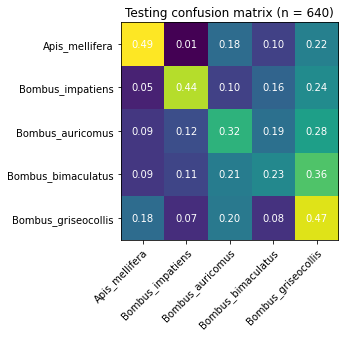

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)
Total convolutional layers: 3
CONV: Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([16, 3, 5, 5])
CONV: Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([32, 16, 5, 5])
CONV: Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([64, 32, 5, 5])


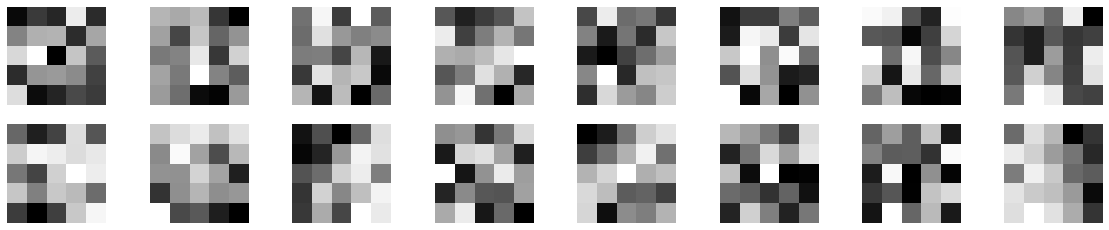

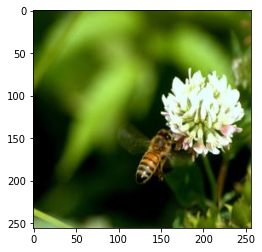

torch.Size([3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([16, 508, 508])
Saving layer 0 feature maps...
torch.Size([32, 504, 504])
Saving layer 1 feature maps...
torch.Size([64, 500, 500])
Saving layer 2 feature maps...
Apis_mellifera: 49.2188
Bombus_impatiens: 43.7500
Bombus_auricomus: 32.0312
Bombus_bimaculatus: 23.4375
Bombus_griseocollis: 46.8750
Best val_acc: 97.6562
-> Starting trial run-1
{'channels': 64, 'dropout': 0.1, 'optimizer': 'sgd', 'processed (yolo)': True}
Running using cropped (yolo) images
Device: cuda:0
Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_

  Epoch: 11 [12456/25632/35930 (71%)]	Loss: 1.214079	Acc: 48.595506%
  Epoch: 11 [15533/32032/35930 (89%)]	Loss: 1.152011	Acc: 48.492133%
Epoch: 11	Loss: 1.220369	Acc: 48.458113
 Validation correct: 579.0 / 1280
Validation: acc: 45.234375%	loss: 0.038407
 Testing correct: 326.0 / 640
Testing: acc: 50.937500%	loss: -11.474526
Best: 10 @ 46.250000% -> epoch target 15
  Epoch: 12 [17/32/35930 (0%)]	Loss: 1.035551	Acc: 53.125000%
  Epoch: 12 [3140/6432/35930 (18%)]	Loss: 1.281947	Acc: 48.818408%
  Epoch: 12 [6309/12832/35930 (36%)]	Loss: 1.219987	Acc: 49.166147%
  Epoch: 12 [9492/19232/35930 (53%)]	Loss: 1.095840	Acc: 49.355241%
  Epoch: 12 [12696/25632/35930 (71%)]	Loss: 1.161054	Acc: 49.531835%
  Epoch: 12 [15878/32032/35930 (89%)]	Loss: 1.222430	Acc: 49.569181%
Epoch: 12	Loss: 1.194471	Acc: 49.610353
 Validation correct: 595.0 / 1280
Validation: acc: 46.484375%	loss: 0.038288
 Testing correct: 318.0 / 640
Testing: acc: 49.687500%	loss: -12.200423
Best: 12 @ 46.484375% -> epoch target 17

  Epoch: 24 [15625/25632/35930 (71%)]	Loss: 0.809228	Acc: 60.958958%
  Epoch: 24 [19458/32032/35930 (89%)]	Loss: 1.095016	Acc: 60.745504%
Epoch: 24	Loss: 0.955390	Acc: 60.779293
 Validation correct: 750.0 / 1280
Validation: acc: 58.593750%	loss: 0.031559
 Testing correct: 352.0 / 640
Testing: acc: 55.000000%	loss: -17.385336
Best: 24 @ 58.593750% -> epoch target 29
  Epoch: 25 [19/32/35930 (0%)]	Loss: 0.916825	Acc: 59.375000%
  Epoch: 25 [4072/6432/35930 (18%)]	Loss: 0.879059	Acc: 63.308458%
  Epoch: 25 [8018/12832/35930 (36%)]	Loss: 0.843259	Acc: 62.484414%
  Epoch: 25 [12006/19232/35930 (53%)]	Loss: 0.893821	Acc: 62.427205%
  Epoch: 25 [16041/25632/35930 (71%)]	Loss: 0.705489	Acc: 62.581929%
  Epoch: 25 [20048/32032/35930 (89%)]	Loss: 0.629913	Acc: 62.587413%
Epoch: 25	Loss: 0.923985	Acc: 62.465906
 Validation correct: 738.0 / 1280
Validation: acc: 57.656250%	loss: 0.031087
 Testing correct: 350.0 / 640
Testing: acc: 54.687500%	loss: -18.703603
Best: 24 @ 58.593750% -> epoch target 2

  Epoch: 37 [21986/25632/35930 (71%)]	Loss: 0.385416	Acc: 85.775593%
  Epoch: 37 [27434/32032/35930 (89%)]	Loss: 0.359097	Acc: 85.645604%
Epoch: 37	Loss: 0.383449	Acc: 85.560813
 Validation correct: 1065.0 / 1280
Validation: acc: 83.203125%	loss: 0.013805
 Testing correct: 344.0 / 640
Testing: acc: 53.750000%	loss: -23.019317
Best: 37 @ 83.203125% -> epoch target 42
  Epoch: 38 [26/32/35930 (0%)]	Loss: 0.351219	Acc: 81.250000%
  Epoch: 38 [5703/6432/35930 (18%)]	Loss: 0.389699	Acc: 88.666045%
  Epoch: 38 [11366/12832/35930 (36%)]	Loss: 0.146626	Acc: 88.575436%
  Epoch: 38 [16992/19232/35930 (53%)]	Loss: 0.292938	Acc: 88.352745%
  Epoch: 38 [22610/25632/35930 (71%)]	Loss: 0.380946	Acc: 88.210050%
  Epoch: 38 [28137/32032/35930 (89%)]	Loss: 0.467047	Acc: 87.840285%
Epoch: 38	Loss: 0.332040	Acc: 87.631506
 Validation correct: 1116.0 / 1280
Validation: acc: 87.187500%	loss: 0.011247
 Testing correct: 347.0 / 640
Testing: acc: 54.218750%	loss: -28.638404
Best: 38 @ 87.187500% -> epoch targe

  Epoch: 50 [18541/19232/35930 (53%)]	Loss: 0.082051	Acc: 96.407030%
  Epoch: 50 [24726/25632/35930 (71%)]	Loss: 0.088845	Acc: 96.465356%
  Epoch: 50 [30881/32032/35930 (89%)]	Loss: 0.070139	Acc: 96.406718%
Epoch: 50	Loss: 0.090836	Acc: 96.303924
 Validation correct: 1236.0 / 1280
Validation: acc: 96.562500%	loss: 0.002930
 Testing correct: 355.0 / 640
Testing: acc: 55.468750%	loss: -33.078703
Best: 49 @ 97.031250% -> epoch target 54
  Epoch: 51 [31/32/35930 (0%)]	Loss: 0.171106	Acc: 96.875000%
  Epoch: 51 [6229/6432/35930 (18%)]	Loss: 0.081717	Acc: 96.843905%
  Epoch: 51 [12384/12832/35930 (36%)]	Loss: 0.031885	Acc: 96.508728%
  Epoch: 51 [18572/19232/35930 (53%)]	Loss: 0.066019	Acc: 96.568220%
  Epoch: 51 [24684/25632/35930 (71%)]	Loss: 0.057072	Acc: 96.301498%
  Epoch: 51 [30854/32032/35930 (89%)]	Loss: 0.087214	Acc: 96.322428%
Epoch: 51	Loss: 0.086867	Acc: 96.418035
 Validation correct: 1239.0 / 1280
Validation: acc: 96.796875%	loss: 0.002565
 Testing correct: 346.0 / 640
Testing: 

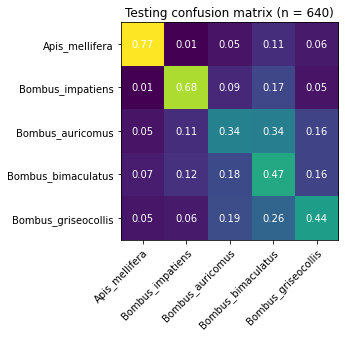

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)
Total convolutional layers: 3
CONV: Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([16, 3, 5, 5])
CONV: Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([32, 16, 5, 5])
CONV: Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([64, 32, 5, 5])


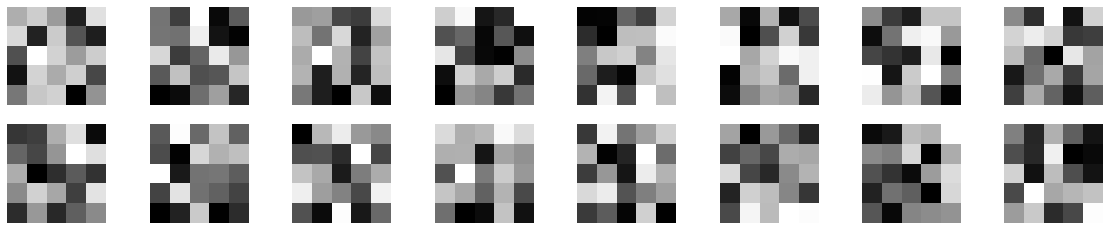

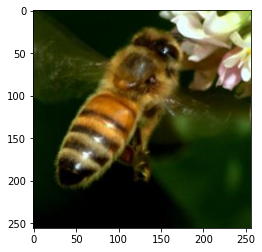

torch.Size([3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([16, 508, 508])
Saving layer 0 feature maps...
torch.Size([32, 504, 504])
Saving layer 1 feature maps...
torch.Size([64, 500, 500])
Saving layer 2 feature maps...
Apis_mellifera: 77.3438
Bombus_impatiens: 67.9688
Bombus_auricomus: 34.3750
Bombus_bimaculatus: 46.8750
Bombus_griseocollis: 43.7500
Best val_acc: 97.4219
-> Starting trial run-2
{'channels': 64, 'dropout': 0.2, 'optimizer': 'sgd', 'processed (yolo)': False}
Running using uncropped (plain) images
Device: cuda:0
Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear

  Epoch: 11 [8558/32032/35930 (89%)]	Loss: 1.510965	Acc: 26.717033%
Epoch: 11	Loss: 1.577243	Acc: 26.685221
 Validation correct: 331.0 / 1280
Validation: acc: 25.859375%	loss: 0.049529
 Testing correct: 191.0 / 640
Testing: acc: 29.843750%	loss: -1.020180
Best: 11 @ 25.859375% -> epoch target 16
  Epoch: 12 [10/32/35930 (0%)]	Loss: 1.525587	Acc: 31.250000%
  Epoch: 12 [1794/6432/35930 (18%)]	Loss: 1.560091	Acc: 27.891791%
  Epoch: 12 [3598/12832/35930 (36%)]	Loss: 1.552640	Acc: 28.039277%
  Epoch: 12 [5359/19232/35930 (53%)]	Loss: 1.551716	Acc: 27.865017%
  Epoch: 12 [7170/25632/35930 (71%)]	Loss: 1.512685	Acc: 27.972846%
  Epoch: 12 [9000/32032/35930 (89%)]	Loss: 1.539369	Acc: 28.096903%
Epoch: 12	Loss: 1.566491	Acc: 28.079599
 Validation correct: 333.0 / 1280
Validation: acc: 26.015625%	loss: 0.049419
 Testing correct: 194.0 / 640
Testing: acc: 30.312500%	loss: -1.406559
Best: 12 @ 26.015625% -> epoch target 17
  Epoch: 13 [7/32/35930 (0%)]	Loss: 1.606167	Acc: 21.875000%
  Epoch: 13 

In [ ]:
length = 256
skip_all = False

classes = ['Apis_mellifera','Bombus_impatiens','Bombus_auricomus','Bombus_bimaculatus','Bombus_griseocollis']
#classes = ['Bombus_auricomus','Bombus_bimaculatus','Bombus_griseocollis']

ABS_PATH_TRAIN = '/m2docs/res/data/train'
ABS_PATH_VALID = '/m2docs/res/data/valid'
ABS_PATH_TEST = '/m2docs/res/data/test'
ABS_PATH_TRAIN_RAW = '/m2docs/res/data_raw/train'
ABS_PATH_VALID_RAW = '/m2docs/res/data_raw/valid'
ABS_PATH_TEST_RAW = '/m2docs/res/data_raw/test'

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def load(dir_name, batch_size, shuffle = False):
    return(
        #create a data loader
        torch.utils.data.DataLoader(
            datasets.ImageFolder(root = dir_name, 
                                 transform = transforms.Compose([
                                     transforms.Resize((length,length)),
                                     transforms.ToTensor()
                                 ])),
            batch_size = batch_size,
            num_workers = 8,
            shuffle = shuffle,
        )
    )

class Net(nn.Module):
    def __init__(self, hparams):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(p = hparams[HP_DROPOUT])
        
        self.conv1 = nn.Conv2d(3, int(hparams[HP_NUM_UNITS]/4), 5)
        #self.conv2 = nn.Conv2d(int(hparams[HP_NUM_UNITS]/16), int(hparams[HP_NUM_UNITS]/12), 2)
        #self.conv3 = nn.Conv2d(int(hparams[HP_NUM_UNITS]/12), int(hparams[HP_NUM_UNITS]/8), 2)
        #self.conv4 = nn.Conv2d(int(hparams[HP_NUM_UNITS]/8), int(hparams[HP_NUM_UNITS]/4), 5)
        self.conv5 = nn.Conv2d(int(hparams[HP_NUM_UNITS]/4), int(hparams[HP_NUM_UNITS]/2), 5)
        self.conv6 = nn.Conv2d(int(hparams[HP_NUM_UNITS]/2), hparams[HP_NUM_UNITS], 5)
                
        self.fc1 = nn.Linear(hparams[HP_NUM_UNITS]*28**2, length)
        self.fc2 = nn.Linear(length, int(length/2))
#         self.fc3 = nn.Linear(int(length/2), int(length/4))
        self.fc3 = nn.Linear(int(length/2), len(classes))

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
#         x = self.dropout(F.relu(self.pool(self.conv2(x))))
#         x = self.dropout(F.relu(self.pool(self.conv3(x))))
#         x = self.dropout(F.relu(self.pool(self.conv4(x))))
        x = self.dropout(F.relu(self.pool(self.conv5(x))))
        x = (F.relu(self.pool(self.conv6(x))))
        #print(x.size())
        x = x.view(x.size(0),-1)
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        x = self.dropout(self.fc3(x))
        return x

def validate(network,device,load_valid,optimizer,criterion = nn.CrossEntropyLoss()):
    network.train().to(device)
    correct = 0
    valid_loss = 0
    for index, data in enumerate(load_valid, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        valid_loss += loss.item()

        # gather accuracy stats:
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).float().sum().item()
    print(" Validation correct: {} / {}".format(correct,len(load_valid.dataset)))  
    accuracy = 100 * correct / len(load_valid.dataset)
    valid_loss = valid_loss / len(load_valid.dataset)
    return accuracy, valid_loss

def test(network,device,load_test,criterion = nn.CrossEntropyLoss()):
    network.eval().to(device)
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for index, data in enumerate(load_test, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # forward + backward + optimize
            outputs = network(inputs).to(device)
            test_loss += nn.functional.nll_loss(outputs, labels).item()

            # gather accuracy stats:
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).float().sum().item()
    print(" Testing correct: {} / {}".format(correct,len(load_test.dataset)))        
    accuracy = 100 * correct / len(load_test.dataset)
    valid_loss = test_loss / len(load_test.dataset)
    return (accuracy, test_loss)

def train(max_epochs, min_epochs, epoch_stretch, batch_size, train_path, valid_path, test_path, labels, hparams, writer):
    epochs = max_epochs
    class_names = labels
    num_classes = len(class_names)
    train_batch = batch_size
    test_batch = 128
    SAVE_PATH = '/m2docs/res/trained_models/model'

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    net = Net(hparams).to(device)
    print(net)
    print("\n")
    
    tag = datetime.datetime.now().strftime(".%Y%m%d-%H%M%S")
    
    VISUAL_OUT = '/m2docs/res/visualizations/' + tag + "/"
    if not os.path.exists(VISUAL_OUT):
        os.makedirs(VISUAL_OUT)

    criterion = nn.CrossEntropyLoss()
    
    # Choose optimizer: (from ['adam','sgd','adagrad'])
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    if (hparams[HP_OPTIMIZER] == 'adam'):
        optimizer = optim.Adam(net.parameters(), lr = .001)
    elif (hparams[HP_OPTIMIZER] == 'sgd'):
        optimizer = optim.SGD(net.parameters(), lr = .001, momentum=0.1)
    elif (hparams[HP_OPTIMIZER] == 'adagrad'):
        optimizer = optim.Adagrad(net.parameters(), lr = .001)
    else:
        # default
        optimizer = optim.Adam(net.parameters(), lr = 0.001)

    torch.manual_seed(417)
    
    load_train = load(train_path, batch_size, shuffle=True)
    load_valid = load(valid_path, batch_size, shuffle=True)
    load_test  = load(test_path, batch_size, shuffle=True)

    validation_accuracies = []
    best_epoch = 0
    epoch = 0
    killed = False
    print(type(list(net.children())[2].weight))
    while (epoch <= best_epoch + epoch_stretch or epoch < min_epochs) and epoch < max_epochs and not killed:
        net.train()
        run_loss = 0.0
        sum_loss = 0.0
        count = 0
        correct = 0.0
        categorical_correct = [0.0 for i in range(num_classes)]
        for index, data in enumerate(load_train, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # gather accuracy stats:
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).float().sum().item()
            for i in range(num_classes):
                categorical_correct[i] += ((predicted==i) == (labels==i)).float().sum().item()
                #print(classes[i],categorical_correct[i]/((index+1)*batch_size))
            
            # print statistics
            run_loss += loss.item()
            sum_loss += loss.item()
            count += 1 
            if index % 200 == 0:    # print every 200 mini-batches
                print('  Epoch: {} [{}/{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}%'.format(
                    epoch, int(correct), (index + 1) * batch_size, len(load_train.dataset),
                    100. * index / len(load_train), loss.item(), 100. * correct / ((index+1) * batch_size)))
                run_loss = 0.0
        accuracy = 100. * correct / len(load_train.dataset)
        print('Epoch: {}\tLoss: {:.6f}\tAcc: {:.6f}'.format(
                epoch, sum_loss/count, accuracy))
        writer.add_scalar("Loss/train", sum_loss/count, epoch)
        writer.add_scalar("Acc/train", accuracy, epoch)
        
        modules_list = iter(net.named_modules())
        next(modules_list)
        for module in modules_list:
            try:
                writer.add_histogram("Model/"+module[0]+".weights", module[1].weight, epoch)
                writer.add_histogram("Model/"+module[0]+".bias", module[1].bias, epoch)
            except:
                pass
        # Categorical accuracy:
        for i in range(num_classes):
            writer.add_scalar("Acc/" + classes[i],categorical_correct[i]/len(load_train.dataset), epoch)
        torch.save(net.state_dict(), SAVE_PATH + tag + "-progress")
        
        # get validation accuracy: 
        valid_acc, valid_loss = validate(net, device, load_valid, optimizer, criterion)
        writer.add_scalar("Loss/valid", valid_loss, epoch)
        writer.add_scalar("Acc/valid", valid_acc, epoch)
        print('Validation: acc: {:.6f}%\tloss: {:.6f}'.format(
                valid_acc, valid_loss))
        validation_accuracies.append(valid_acc)
        best_epoch = validation_accuracies.index(max(validation_accuracies))
        
        # get test accuracy: 
        test_acc, test_loss = test(net, device, load_test, criterion)
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("Acc/test", test_acc, epoch)
        print('Testing: acc: {:.6f}%\tloss: {:.6f}'.format(
                test_acc, test_loss))
        
        # this is the best epoch so far, save these weights:
        if (best_epoch == epoch):
            torch.save(net.state_dict(), SAVE_PATH + tag + "-best")
        if (epoch >= 2):
            if (validation_accuracies[epoch] == 100/num_classes):
                killed = True
                print("[!] This run has failed, accuracies are bad. Aborting.")
        
        print('Best: {} @ {:.6f}% -> epoch target {}'.format(best_epoch,validation_accuracies[best_epoch],max([best_epoch+epoch_stretch,min_epochs])))
        epoch += 1
        
    print('Done training.')
    torch.save(net.state_dict(), SAVE_PATH + tag + "-final")
    
    ## TODO: test here

    prediction_list = torch.zeros(0,dtype=torch.long).to(device)
    label_list = torch.zeros(0,dtype=torch.long).to(device)
    
    ## Testing
    net.eval().to(device)
    correct = 0
    valid_loss = 0
    with torch.no_grad():
        for index, data in enumerate(load_test, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = net(inputs)
            valid_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs.data, 1)
            prediction_list = torch.cat([prediction_list, predicted.view(-1)])  
            label_list = torch.cat([label_list, labels.view(-1)])
            #print("Predictions, ground:")
            #print(prediction_list)
            #print(label_list)
            correct += (predicted == labels).float().sum().item()
    print(" Testing correct: {} / {}".format(correct,len(load_test.dataset)))        
    t_acc = 100 * correct / len(load_test.dataset)
    t_loss = valid_loss / len(load_test.dataset)

    
    matrix = confusion_matrix(label_list.cpu().numpy(), prediction_list.cpu().numpy())
    print(matrix)
    fig, ax = plt.subplots()
    im = ax.imshow(matrix)
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, "{:4.2f}".format(matrix[i, j]/sum(matrix[i])),
                           ha="center", va="center", color="w")

    ax.set_title("Testing confusion matrix (n = {})".format(len(load_test.dataset)))

    plt.show()
    writer.add_figure('Testing/conf',fig)
    
    if (hparams[HP_YOLOCROPPED]):
        # cropped images
        savefeatures(net, writer, image = "/m2docs/res/data/test/Apis_mellifera/5704-2.jpg")
    else:
        savefeatures(net, writer, image = "/m2docs/res/data_raw/test/Apis_mellifera/5704-2.jpg")
    
    ## Visualise features
#     FV = FilterVisualizer(net,VISUAL_OUT)
#     image_out = reconstructions_single_layer(list((net.children()))[2],'Layer 1 Block 1 Conv1',
#                                              list(range(6,12)),n_cols=3,
#                                              save_fig=True,album_hash=None)
    
    class_accuracy=100*matrix.diagonal() / matrix.sum(1)
    #print(classes)
    #print(class_accuracy)
    for i in range(len(classes)):
        print("{}: {:.4f}".format(classes[i],class_accuracy[i]))
    print("Best val_acc: {:6.4f}".format(max(validation_accuracies)))
    return max(validation_accuracies)

# magic here.
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        run_writer = SummaryWriter(log_dir = run_dir)            
        if (hparams[HP_YOLOCROPPED]):
            train_path = ABS_PATH_TRAIN
            valid_path = ABS_PATH_VALID
            test_path = ABS_PATH_TEST
            print("Running using cropped (yolo) images")
        else:
            train_path = ABS_PATH_TRAIN_RAW
            valid_path = ABS_PATH_VALID_RAW
            test_path = ABS_PATH_TEST_RAW
            print("Running using uncropped (plain) images")
        
        accuracy = train(max_epochs = 100, min_epochs = 15, epoch_stretch = 5, batch_size = 32, train_path = train_path, valid_path = valid_path, test_path = test_path, labels = classes, hparams = hparams, writer = run_writer)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

if (skip_all is False): 
    HP_NUM_UNITS = hp.HParam('channels', hp.Discrete([64, 128, 256]))
    HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
    #HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['sgd','adagrad']))
    HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['sgd']))
    HP_YOLOCROPPED = hp.HParam('processed (yolo)', hp.Discrete([True, False]))
    METRIC_ACCURACY = 'accuracy'
    
    hpdirname = 'runs/' + (datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ':hparam_tuning')
    with tf.summary.create_file_writer(hpdirname).as_default():
        hp.hparams_config(
            hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, HP_YOLOCROPPED],
            metrics=[hp.Metric(METRIC_ACCURACY, display_name='best accuracy (validation)')]
        )
    
    session_num = 0
    for num_units in HP_NUM_UNITS.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for optimizer in HP_OPTIMIZER.domain.values:
                for yolo in HP_YOLOCROPPED.domain.values:
                    hparams = {
                        HP_NUM_UNITS: num_units,
                        HP_DROPOUT: float("%0.2f"%float(dropout_rate)),
                        HP_OPTIMIZER: optimizer,
                        HP_YOLOCROPPED: yolo,
                    }
                    torch.cuda.empty_cache()
                    run_name = "run-%d" % session_num
                    print("-> Starting trial %s" % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    if hparams[HP_YOLOCROPPED]:
                        run(os.path.join(hpdirname, '_' + str(session_num) + '_true'), hparams)
                    else:
                        run(os.path.join(hpdirname, '_' + str(session_num)) + '_false', hparams)
                    session_num += 1

# 2 stage classifier

1. Train to detect *Apis Mellifera* vs. *Bombus Auricomus* vs. a merged set of the other classes.
2. Train a second model to tell apart the other three classes.'
3. Note that both of these datasets will by default be unbalanced unless something is changed above.
4. When running detections, if the first model's confidence is below a threshold, apply the second model to see if there is an improved prediction.

`todo: balance datasets`

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os, datetime, math

from torch.utils.tensorboard import SummaryWriter 
length = 512
var_droupout = 0.2
skip_all = True
tag1 = ':' + str(length) + '_STAGE-1_' + str(var_droupout)
tag2 = ':' + str(length) + '_STAGE-2_' + str(var_droupout)
writer1 = SummaryWriter(log_dir = os.path.join('runs/',(datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + tag1)))
writer2 = SummaryWriter(log_dir = os.path.join('runs/',(datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + tag2)))
print("tensorboard writing"+tag1)
print("tensorboard writing"+tag2)

classes1 = ['Apis_mellifera','Bombus_impatiens','Merged']
classes2 = ['Bombus_auricomus','Bombus_bimaculatus','Bombus_griseocollis']

ABS_PATH_TRAIN1 = '/m2docs/res/data1/train'
ABS_PATH_VALID1 = '/m2docs/res/data1/valid'
ABS_PATH_TEST1 = '/m2docs/res/data1/test'
ABS_PATH_TRAIN2 = '/m2docs/res/data2/train'
ABS_PATH_VALID2 = '/m2docs/res/data2/valid'
ABS_PATH_TEST2 = '/m2docs/res/data2/test'

class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

class FilterVisualizer():
        def __init__(self, network, OUTPUT_DIR):
                self.model = nn.Sequential(*list(network.children())[:-2]).cuda().eval()
                self.network = network
                self.OUTPUT_DIR = OUTPUT_DIR

        def visualize(self, sz, layer, filter, upscaling_steps=12, upscaling_factor=1.2, lr=0.1, opt_steps=20, blur=None, save=False, print_losses=False):
                with Torch.no_grad():
                    img = (np.random.random((sz, sz, 3)) * 20 + 128.)/255.
    #                img = np.random.uniform(0, 1, size=(sz, sz, 3)).astype(np.float32)
    #                median_filter_size = 4 if sz < 100 else 8
    #                img = scipy.ndimage.filters.median_filter(img, [median_filter_size,median_filter_size,1])

                    activations = SaveFeatures(layer)  # register hook

                    for i in range(upscaling_steps):  # scale the image up upscaling_steps times
                            train_tfms, val_tfms = tfms_from_model(network, sz)
                            img_var = V(val_tfms(img)[None], requires_grad=True)  # convert image to Variable that requires grad
                            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
                            if i > upscaling_steps/2:
                                    opt_steps_ = int(opt_steps*1.3)
                            else:
                                    opt_steps_ = opt_steps
                            for n in range(opt_steps_):  # optimize pixel values for opt_steps times
                                    optimizer.zero_grad()
                                    self.model(img_var)
                                    loss = -1 * activations.features[0, filter].mean()
                                    if print_losses:
                                            if i%3==0 and n%5==0:
                                                    print(f'{i} - {n} - {float(loss)}')
                                    loss.backward()
                                    optimizer.step()
                            img = val_tfms.denorm(np.rollaxis(to_np(img_var.data),1,4))[0]
                            self.output = img
                            sz = int(upscaling_factor * sz)  # calculate new image size
                            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
                            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
                    activations.close()
                    return np.clip(self.output, 0, 1)
        
        def get_transformed_img(self,img,sz):
            with Torch.no_grad():
                train_tfms, val_tfms = tfms_from_model(network, sz)
                return val_tfms.denorm(np.rollaxis(to_np(val_tfms(img)[None]),1,4))[0]
        
        def most_activated(self, image, layer, limit_top=None):
            with Torch.no_grad():
                train_tfms, val_tfms = tfms_from_model(network, 224)
                transformed = val_tfms(image)

                activations = SaveFeatures(layer)  # register hook
                self.model(V(transformed)[None]);
                
                mean_act = [activations.features[0,i].mean().data.cpu().numpy()[0] for i in range(activations.features.shape[1])]
                activations.close()
                return mean_act

def plot_reconstructions_single_layer(imgs,layer_name,filters,
                                      n_cols=3,
                                      cell_size=4,save_fig=True,
                                      album_hash=None):
        n_rows = ceil((len(imgs))/n_cols)

        fig,axes = plt.subplots(n_rows,n_cols, figsize=(cell_size*n_cols,cell_size*n_rows))
                    
        for i,ax in enumerate(axes.flat):
                ax.grid(False)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                if i>=len(filters):
                        pass

                ax.set_title(f'fmap {filters[i]}')

                ax.imshow(imgs[i])
        fig.suptitle(f'cnn {layer_name}', fontsize="x-large",y=1.0)
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        save_name = layer_name.lower().replace(' ','_')
        if save_fig:
                plt.savefig(f'' + OUTPUT_DIR + 'network_{save_name}_fmaps_{"_".join([str(f) for f in filters])}.png')
                plt.close()
                return True
        else:
                plt.show()
                return None

def reconstructions_single_layer(layer,layer_name,filters,
                                 init_size=56, upscaling_steps=12, 
                                 upscaling_factor=1.2, 
                                 opt_steps=20, blur=5,
                                 lr=1e-1,print_losses=False,
                                 n_cols=3, cell_size=4,
                                 save_fig=True,album_hash=None):
        
        imgs = []
        for i in range(len(filters)):
                imgs.append(FV.visualize(init_size,layer, filters[i], 
                            upscaling_steps=upscaling_steps, 
                            upscaling_factor=upscaling_factor, 
                            opt_steps=opt_steps, blur=blur,
                            lr=lr,print_losses=print_losses))
                
        return plot_reconstructions_single_layer(imgs,layer_name,filters,
                                                 n_cols=n_cols,cell_size=cell_size,
                                                 save_fig=save_fig,album_hash=album_hash)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def load(dir_name, batch_size, shuffle = False):
    return(
        #create a data loader
        torch.utils.data.DataLoader(
            datasets.ImageFolder(root = dir_name, transform = transforms.ToTensor()),
            batch_size = batch_size,
            num_workers = 2,
            shuffle = shuffle
        )
    )

# Layer/network 1:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(p = var_droupout)
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        
        self.fc1 = nn.Linear(128*28*28, length)
        self.fc2 = nn.Linear(length, int(length/2))
        #self.fc3 = nn.Linear(int(length/2), int(length/4))
        self.fc3 = nn.Linear(int(length/2), 5)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = self.dropout(F.relu(self.pool(self.conv2(x))))
        x = self.dropout(F.relu(self.pool(self.conv3(x))))
        x = (F.relu(self.pool(self.conv4(x))))
        #print(x.size())
        x = x.view(x.size(0),-1)
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(self.fc3(x))
        return x
    
# Layer/network 2:    
class Net2(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(p = var_droupout)
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        
        self.fc1 = nn.Linear(128*28*28, length)
        self.fc2 = nn.Linear(length, int(length/2))
        #self.fc3 = nn.Linear(int(length/2), int(length/4))
        self.fc3 = nn.Linear(int(length/2), 5)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = self.dropout(F.relu(self.pool(self.conv2(x))))
        x = self.dropout(F.relu(self.pool(self.conv3(x))))
        x = (F.relu(self.pool(self.conv4(x))))
        #print(x.size())
        x = x.view(x.size(0),-1)
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(self.fc3(x))
        return x

def validate(network,device,load_valid,criterion = nn.CrossEntropyLoss()):
    network.eval().to(device)
    correct = 0
    valid_loss = 0
    with torch.no_grad():
        for index, data in enumerate(load_valid, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # forward + backward + optimize
            outputs = network(inputs)
            valid_loss += criterion(outputs, labels).item()

            # gather accuracy stats:
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).float().sum().item()
    accuracy = 100 * correct / len(load_valid.dataset)
    valid_loss = valid_loss / len(load_valid.dataset)
    return accuracy , valid_loss

def train(max_epochs = 50, min_epochs = 5, epoch_stretch = 5, train_path = ABS_PATH_TRAIN, valid_path = ABS_PATH_VALID, test_path = ABS_PATH_TEST, labels = classes, batch_size = 24):
    epochs = max_epochs
    class_names = labels
    num_classes = len(class_names)
    train_batch = batch_size
    test_batch = 128
    SAVE_PATH = '/m2docs/res/models'

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    net = Net().to(device)
    print(net)

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr = 0.001)

    torch.manual_seed(417)
    
    load_train = load(train_path, batch_size, shuffle=True)
    load_valid = load(valid_path, batch_size, shuffle=True)
    load_test  = load(test_path, batch_size, shuffle=True)

    validation_accuracies = []
    best_epoch = 0
    epoch = 0
    while (epoch <= best_epoch + epoch_stretch or epoch < min_epochs) and epoch < max_epochs:
        net.train()
        run_loss = 0.0
        sum_loss = 0.0
        count = 0
        correct = 0.0
        categorical_correct = [0.0 for i in range(num_classes)]
        for index, data in enumerate(load_train, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # gather accuracy stats:
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).float().sum().item()
            for i in range(num_classes):
                categorical_correct[i] += ((predicted==i) == (labels==i)).float().sum().item()
                #print(classes[i],categorical_correct[i]/((index+1)*batch_size))
            
            # print statistics
            run_loss += loss.item()
            sum_loss += loss.item()
            count += 1 
            if index % 200 == 0:    # print every 200 mini-batches
                print('  Epoch: {} [{}/{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}%'.format(
                    epoch, int(correct), (index + 1) * batch_size, len(load_train.dataset),
                    100. * index / len(load_train), loss.item(), 100. * correct / ((index+1) * batch_size)))
                run_loss = 0.0
        accuracy = 100. * correct / len(load_train.dataset)
        print('Epoch: {}\tLoss: {:.6f}\tAcc: {:.6f}'.format(
                epoch, sum_loss/count, accuracy))
        writer.add_scalar("Loss/train", sum_loss/count, epoch)
        writer.add_scalar("Acc/train", accuracy, epoch)
        
        modules_list = iter(net.named_modules())
        next(modules_list)
        for module in modules_list:
            try:
                writer.add_histogram("Model/"+module[0]+".weights", module[1].weight, epoch)
                writer.add_histogram("Model/"+module[0]+".bias", module[1].bias, epoch)
            except:
                pass
        # Categorical accuracy:
        for i in range(num_classes):
            writer.add_scalar("Acc/" + classes[i],categorical_correct[i]/len(load_train.dataset), epoch)
        torch.save(net.state_dict(), SAVE_PATH+"_progress")
        
        # get validation accuracy: 
        valid_acc, valid_loss = validate(net, device, load_valid, criterion)
        writer.add_scalar("Loss/valid", valid_loss, epoch)
        writer.add_scalar("Acc/valid", valid_acc, epoch)
        print('Validation: acc: {:.6f}%\tloss: {:.6f}'.format(
                valid_acc, valid_loss))
        validation_accuracies.append(valid_acc)
        best_epoch = validation_accuracies.index(max(validation_accuracies))
        print('Best: {} @ {:.6f}% -> epoch target {}'.format(best_epoch,validation_accuracies[best_epoch],max([best_epoch+epoch_stretch,min_epochs])))
        epoch += 1
        
    print('Done training.')
    torch.save(net.state_dict(), SAVE_PATH)

    prediction_list = torch.zeros(0,dtype=torch.long).to(device)
    label_list = torch.zeros(0,dtype=torch.long).to(device)
              
    with torch.no_grad():
        for data in load_test:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
              
            prediction_list = torch.cat([prediction_list, predicted.view(-1)])  
            label_list = torch.cat([label_list, labels.view(-1)])
    
    matrix = confusion_matrix(label_list.cpu().numpy(), prediction_list.cpu().numpy())
    print(matrix)
    fig, ax = plt.subplots()
    im = ax.imshow(matrix)
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, matrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Testing confusion matrix")

    plt.show()
    writer.add_figure('Testing/conf',fig)
    
    class_accuracy=100*matrix.diagonal() / matrix.sum(1)
    print(classes)
    print(class_accuracy)

if (skip_all is False):
    # setup: create 2-stage directories:
    # data1: first stage: mellifera, impatiens, 3-merged
    %mkdir data1
    %rm -r data1/*
    %mkdir data1/train
    %cp -r data/train/Apis_mellifera data1/train/Apis_mellifera
    %cp -r data/train/Bombus_auricomus data1/train/Bombus_auricomus
    %cp -r data/train/Bombus_bimaculatus data1/train/Merged
    %cp data/train/Bombus_griseocollis/* data1/train/Merged
    %cp data/train/Bombus_impatiens/* data1/train/Merged
    %mkdir data1/valid
    %cp -r data/valid/Apis_mellifera data1/valid/Apis_mellifera
    %cp -r data/valid/Bombus_auricomus data1/valid/Bombus_auricomus
    %cp -r data/valid/Bombus_bimaculatus data1/valid/Merged
    %cp data/valid/Bombus_griseocollis/* data1/valid/Merged
    %cp data/valid/Bombus_impatiens/* data1/valid/Merged
    %mkdir data1/test
    %cp -r data/test/Apis_mellifera data1/test/Apis_mellifera
    %cp -r data/test/Bombus_auricomus data1/test/Bombus_auricomus
    %cp -r data/test/Bombus_bimaculatus data1/test/Merged
    %cp data/test/Bombus_griseocollis/* data1/test/Merged
    %cp data/test/Bombus_impatiens/* data1/test/Merged

    # data2: auricomus vs bimaculatus vs griseocollis
    %mkdir data2
    %rm -r data2/*
    %mkdir data2/train
    %cp -r data/train/Bombus_bimaculatus data2/train/Bombus_bimaculatus
    %cp -r data/train/Bombus_griseocollis data2/train/Bombus_griseocollis
    %cp -r data/train/Bombus_impatiens data2/train/Bombus_impatiens
    %mkdir data2/valid
    %cp -r data/valid/Bombus_bimaculatus data2/valid/Bombus_bimaculatus
    %cp -r data/valid/Bombus_griseocollis data2/valid/Bombus_griseocollis
    %cp -r data/valid/Bombus_impatiens data2/valid/Bombus_impatiens
    %mkdir data2/test
    %cp -r data/test/Bombus_bimaculatus data2/test/Bombus_bimaculatus
    %cp -r data/test/Bombus_griseocollis data2/test/Bombus_griseocollis
    %cp -r data/test/Bombus_impatiens data2/test/Bombus_impatiens
    
    # train
    train(max_epochs = 160, min_epochs = 70, epoch_stretch = 15, train_path = ABS_PATH_TRAIN, valid_path = ABS_PATH_VALID, test_path = ABS_PATH_TEST, labels = classes, batch_size = 32)